# Field of view optimisation for airborne sensor performance

This notebook implements a variation of the performance model developed by T M Goss *et al.*. *Field of View Selection for Optimal Airborne Imaging Sensor Performance*, Proc SPIE, Vol 9071, doi:10.1117/12.2049911, 2014(, \url{http://proceedings.spiedigitallibrary.org/proceeding.aspx?articleid=1878628}).  We also use the material developed in *Electro-Optical System Analysis and Design: A Radiometry Perspective*, CJ Willers, SPIE, DOI: 10.1117/3.1001964, 2013 (\url{http://spie.org/Publications/Book/2021423}).  The first reference is identified as [G] and the second reference is identified as [W] in the text below.  If no reference is given, [G] is implied.

The present form of the model can account for atmospheric transmittance and path radiance effects, but the present calculation does not include this. The results presented here therefore only apply to short-range observations.

The model is a much simplified version of reality, and could benefit from improvement in many areas, but even in its present form it is already quite useful. In particular the absence of atmospheric modelling is somewhat restrictive, but can easily be overcome. The model author [G] stated the following (reasonable) constraints:

The model is useful to compare similar imaging sensors. The optimization and comparison process
assumes the imaging sensor is well designed and that the following design aspects are taken care of:

1.  The optical design is such that the exit pupil is placed close to the front lens/window and limited vignetting is permitted thereby ensuring that the real optical aperture diameter equal to the theoretical optical aperture.
1. The optics is always optimally focused.
1. The optical design is such that no significant stray light or glare issues exist.
1. The electronic design is such that no significant additional noise sources exist i.e. other than those identified in this paper.

Similarly the performance of any thermal imaging sensor may be optimized within the constraints of the application
using the model, for comparing  thermal imagers. The optimization and comparison process assumes the thermal imaging sensor is well designed and that the following design aspects are taken care of:

1.  The same assumptions regarding the optical and electronic designs above apply except that vignetting is not permitted.
1. The cold stop efficiency is 100% (achieved by imaging the entrance pupil onto the cold stop).
1. A cold filter ensures no out-of-band radiation reaches the detector pixels.
1. The detector temperature regulation is sufficient and no low frequency noise components compromise the thermal imaging sensor’s performance i.e. only white noise is present.



# Prepare environment

This report is created from an IPython notebook which includes all the code to calculate the results.  

In [1]:
# to prepare the Python environment
import numpy as np
import scipy as sp
import pandas as pd
import os.path
from scipy.optimize import curve_fit
from scipy import interpolate
from scipy import integrate
from scipy import signal
from scipy import ndimage
import matplotlib.pyplot as plt
import scipy.constants as const
import pickle

import collections

%matplotlib inline

# %reload_ext autoreload
# %autoreload 2

import pyradi.ryplot as ryplot
import pyradi.ryplanck as ryplanck
import pyradi.ryfiles as ryfiles
import pyradi.rymodtran as rymodtran
import pyradi.ryutils as ryutils

from IPython.display import HTML
from IPython.display import Image
from IPython.display import display
from IPython.display import FileLink, FileLinks

import matplotlib as mpl
mpl.rc("savefig", dpi=300)
mpl.rc('figure', figsize=(10,8))
# %config InlineBackend.figure_format = 'svg'
pim = ryplot.ProcessImage()
pd.set_option('display.max_columns', 80) # Number of columns in display
pd.set_option('display.width', 80) # display width - how many chars
pd.set_option('display.max_colwidth', 150)

In [2]:
# to define the sensor parameters used in this analysis

foclen = 1. # normalised focal length in m

# read the excel spreadsheet containing the sensor data and extract the example data
dfS = pd.read_excel('data/FOV-optimisation-parameters.xlsx', 'Sheet1', index_col=None, na_values=['NA'])
dfS.set_index(keys='Sensor',inplace=True)

# get a list of the spectral band definitions from the data set
dfS.loc['Spectral band Mid'] = (dfS.loc['Spectral band Lo'] + dfS.loc['Spectral band Hi']) / 2.
specBands = dfS.loc['Band'].unique()
wlcs = {}
for specBand in specBands:
    wlcs[specBand] = dfS.loc['Spectral band Mid'][dfS.loc['Band']==specBand][0]

# get list of MTF labels and matching masks
mtfLabels = dfS.loc['MTF label'].unique()
dOptics = {}
for mtfLabel in mtfLabels:
    dOptics[mtfLabel] = dfS.loc['Pupil mask'][dfS.loc['MTF label']==mtfLabel][0]

# get max spatial frequency for sensor aperture and wavelength
dfS.loc['SpatFreqMax cy/m'] = dfS.loc['Optics diameter'] / dfS.loc['Spectral band Mid']
dfS = dfS.append(pd.DataFrame(index=['SpatFreq cy/m']))
for colname in dfS.columns.values:
    dfS.loc['SpatFreq cy/m'][colname] = np.linspace(0, dfS.loc['SpatFreqMax cy/m'][colname], 100)

print(specBands)
print(wlcs)
print(mtfLabels)
print(dOptics)
print(dfS.drop('SpatFreq cy/m', axis=0))


[u'Visible' u'MWIR']
{u'Visible': 5.399999999999999e-07, u'MWIR': 4.350000000000001e-06}
[u'Central 0.25' u'No obscuration']
{u'No obscuration': u'data/mask00.png', u'Central 0.25': u'data/mask01.png'}
                          MWIR Sensor A    MWIR Sensor B     Vis Sensor A  \
Sensor                                                                      
Band                               MWIR             MWIR          Visible   
Sensor Type                         MCT              MCT             CMOS   
Spectral band Lo                3.7e-06          3.7e-06          4.8e-07   
Spectral band Hi                  5e-06            5e-06            6e-07   
Pixels H                            640              640             1280   
Pixels V                            512              512              720   
Pixel size                      1.5e-05          1.5e-05          5.5e-06   
Fill factor                        0.98             0.98             0.98   
Quantum efficiency          

# Sensor Model

A comprehensive CCD and CMOS staring array sensor model is provided in the pyradi [`rystare`](http://nelisw.github.io/pyradi-docs/_build/html/rystare.html) module. The [`rystare`](http://nelisw.github.io/pyradi-docs/_build/html/rystare.html) model is originally based on the Matlab code described in *'High-level numerical simulations of noise in solid-state photosensors: review and tutorial'* by Mikhail Konnik and James Welsh, arXiv:1412.4031v1 [astro-ph.IM], available [here](http://arxiv.org/pdf/1412.4031.pdf). Good references for this work include James R Janesick's books ['Photon Transfer'](http://spie.org/Publications/Book/725073) and ['Scientific Charge-Coupled Devices'](http://spie.org/Publications/Book/374903).  Konnik's model is also implemented in Python as described in  notebook 09b of this series, available here: \url{http://nbviewer.jupyter.org/github/NelisW/ComputationalRadiometry/blob/master/09b-StaringArrayDetectors.ipynb}

As is evident in the rystare model block diagram, the model covers only the sensor signal path, including noise, signal integration and signal conditioning (photon signal generation is not part of this model).
The components of the rystare model are shown below:

![''](images/camerascheme-horiz-labelled.png)

The rystare model is used as a reference for this model, there is not a one-to-one mapping between elements of the two models.


## Source spectral content

The target object will either radiate by its own thermal self-emittance, reflected incident light, or both.  In the visible and near infrared bands the signal is mostly caused by reflection. At wavelengths beyond 6 $\mu$m the signal is mostly caused by thermal self-emissition.  In the 3--5 $\mu$m spectral band the signal is caused by both sources.

We will be using the colour temperature as an approximation of source spectral content, in the visible and near infrared parts of the spectum.  We will however use the sun's colour temperature for all spectral bands, because the sun's colour temperature is also approximately equal to the surface temperature.



<http://sizes.com/units/color_temperature.htm>  
<https://www.firstrays.com/bb1-1286570267-680/start/color_temp.htm>  
<http://www.clarkvision.com/articles/night.photography.image.processing/>  


We must be careful when using colour temperature, it does not mean that the object has that temperature. It does not even mean that the spectral content of the object can be described by a scaled spectrum of a radiator at that temperature. The colour temperature's only significance is that it very broadly describes the visual colour of an object.
From <https://en.wikipedia.org/wiki/Color_temperature>
''The color temperature of a light source is the temperature of an ideal blackbody radiator that radiates light of comparable hue to that of the light source. Color temperature is a characteristic of visible light that has important applications in lighting, photography, videography, publishing, manufacturing, astrophysics, horticulture, and other fields. In practice, color temperature is only meaningful for light sources that do in fact correspond somewhat closely to the radiation of some black body, i.e., those on a line from reddish/orange via yellow and more or less white to blueish white; it does not make sense to speak of the color temperature of, e.g., a green or a purple light. Color temperature is conventionally stated in the unit of absolute temperature, the Kelvin, having the unit symbol K.''

Source temperature is undefined if the source spectrum deviates significantly from the Planck law spectral shape. For example, for sources with little continuum and high spectral line variation (e.g., sodium and mercury lamps with small fluorescence) colour temperature has no meaning.

We will be using the colour temperature as an approximation of source spectral content, in the visible and near infrared parts of the spectum.  We will however use the sun's colour temperature for all spectral bands, because the sun's colour temperature is also approximately equal to the surface temperature.

**The moon's colour temperature:**

<http://www.cast-lighting.com/landscape-articles/moonlighting-landscape-lighting-design-imitates-nature>
''It turns out that the moon absorbs twice as much violet as it does red. For this reason, the moon is slightly reddish. A full moon when it appears directly overhead has a color temperature of about 4,150 K. Compared to incandescent lighting (around 3,000 K), moonlight is slightly blue but not nearly as blue as a bright sunny day (as much as 10,000 K)''
 
''Johannes Purkinje, a 19th century physiologist, found that at very low light levels, the human eye could no longer  perceive the color red, but could still perceive blues and greens. This occurs because the eye's retinal cones (responsible for color perception) require a lot of light. At lower brightness levels, only the retinal rods are activated. These rods (responsible for seeing fine detail and contrast) can only respond to blues and greens.''

''The luminance level at which this perceptual shift occurs is at about .001 candelas/meters. Monlight has about this same luminance levle. This puts moonlight right at the threshold of the Purkinje Shift and this is why the moon appears slightly blue. It should be noted though, that the effect is so slight that the brain easily shifts its perception to judging the moon to be white. If we shift our gaze from the moon to the ground and other objects that it illuminates, the most noticeable effect is not only a blueish color but also an absence of all other colors.''

In [3]:
lx = {'Sun light': [107527,5700,1.0], 
      'Full sky light': [10752,12000,1.0],
      'Overcast day':[1075,6000,1.0],
      'Very dark day':[107,7000,1.0],
      'Twilight': [10.8,10000,1.0],
      'Deep twilight': [1.08,10000,0.8],
      'Full moon': [0.108,4150,0.6],
      'Quarter moon':[0.0108,4150,0.4],
      'Star light': [0.0011,5000,0.2],
      'Overcast night':[0.0001,5000, 0.],
    }

dfPhotRates = pd.DataFrame(lx).transpose()
dfPhotRates.columns = ['Irradiance-lm/m2','ColourTemp','FracPhotop']
  
dfPhotRates.sort_values(by='Irradiance-lm/m2',inplace=True)
print(dfPhotRates)

                Irradiance-lm/m2  ColourTemp  FracPhotop
Overcast night            0.0001        5000         0.0
Star light                0.0011        5000         0.2
Quarter moon              0.0108        4150         0.4
Full moon                 0.1080        4150         0.6
Deep twilight             1.0800       10000         0.8
Twilight                 10.8000       10000         1.0
Very dark day           107.0000        7000         1.0
Overcast day           1075.0000        6000         1.0
Full sky light        10752.0000       12000         1.0
Sun light            107527.0000        5700         1.0


## Relating photometric units with photon rate units


The illuminance table above shows the approximate illuminance levels for different scenarios.  The sensor models below require irradiance levels in units of q/(s.m$^s$), not lx/m$^2$. A conversion between the two unit systems is required.  This conversion requires two information elements: the illuminance magnitude and spectral content.  The magnitude is given in the table, and in the absence of any better information, we would assume the spectral content to be a scaled version of a thermal source at the colour temperature.  This use of colour temperature is extending beyond its original purpose and introduces an element of risk.  Yet the answer with risk is better than no answer at all.

If the luminance exceeds about $3$ lm/(m$^2$sr) [twilight], the eye is light-adapted, and the cones in the retina are operating. Under light-adapted conditions, the eye’s spectral response is called photopic.
If the luminance is less than $3\times 10^{−5}$ lm/(m$^2$sr) [overcast night], the eye is dark-adapted. The cones are no longer sensitive, and the rods sense the light.Under dark-adapted conditions, the eye’s spectral response is called scotopic.

Under scotopic vision, the eye is not sensitive to color and has no foveal vision. Between photopic and scotopic vision, the eye's response is called mesoptic.  Mesopic vision has a spectral response somewhere between photopic and scotopic vision.  In the table above the `FracPhotop` column shows my very rough mixing ratio of photopic and scotopix spectral curves to model mesopic vision.  These values are not validated and are purely guesswork.

The eye's photopic spectral response can be _roughly  approximated_ by:
\begin{equation}
V_\lambda=1.019\exp(-285.51(\lambda - 0.5591)^2).
\end{equation}

The eye's scotopic spectral response can be _roughly  approximated_ by:
\begin{equation}
V_\lambda^\prime=0.99234\exp(-321.1(\lambda - 0.5028)^2).
\end{equation}

There are data tables from the CIE standards that describe this shape more accurately but this approximation is sufficient for the present requirement.

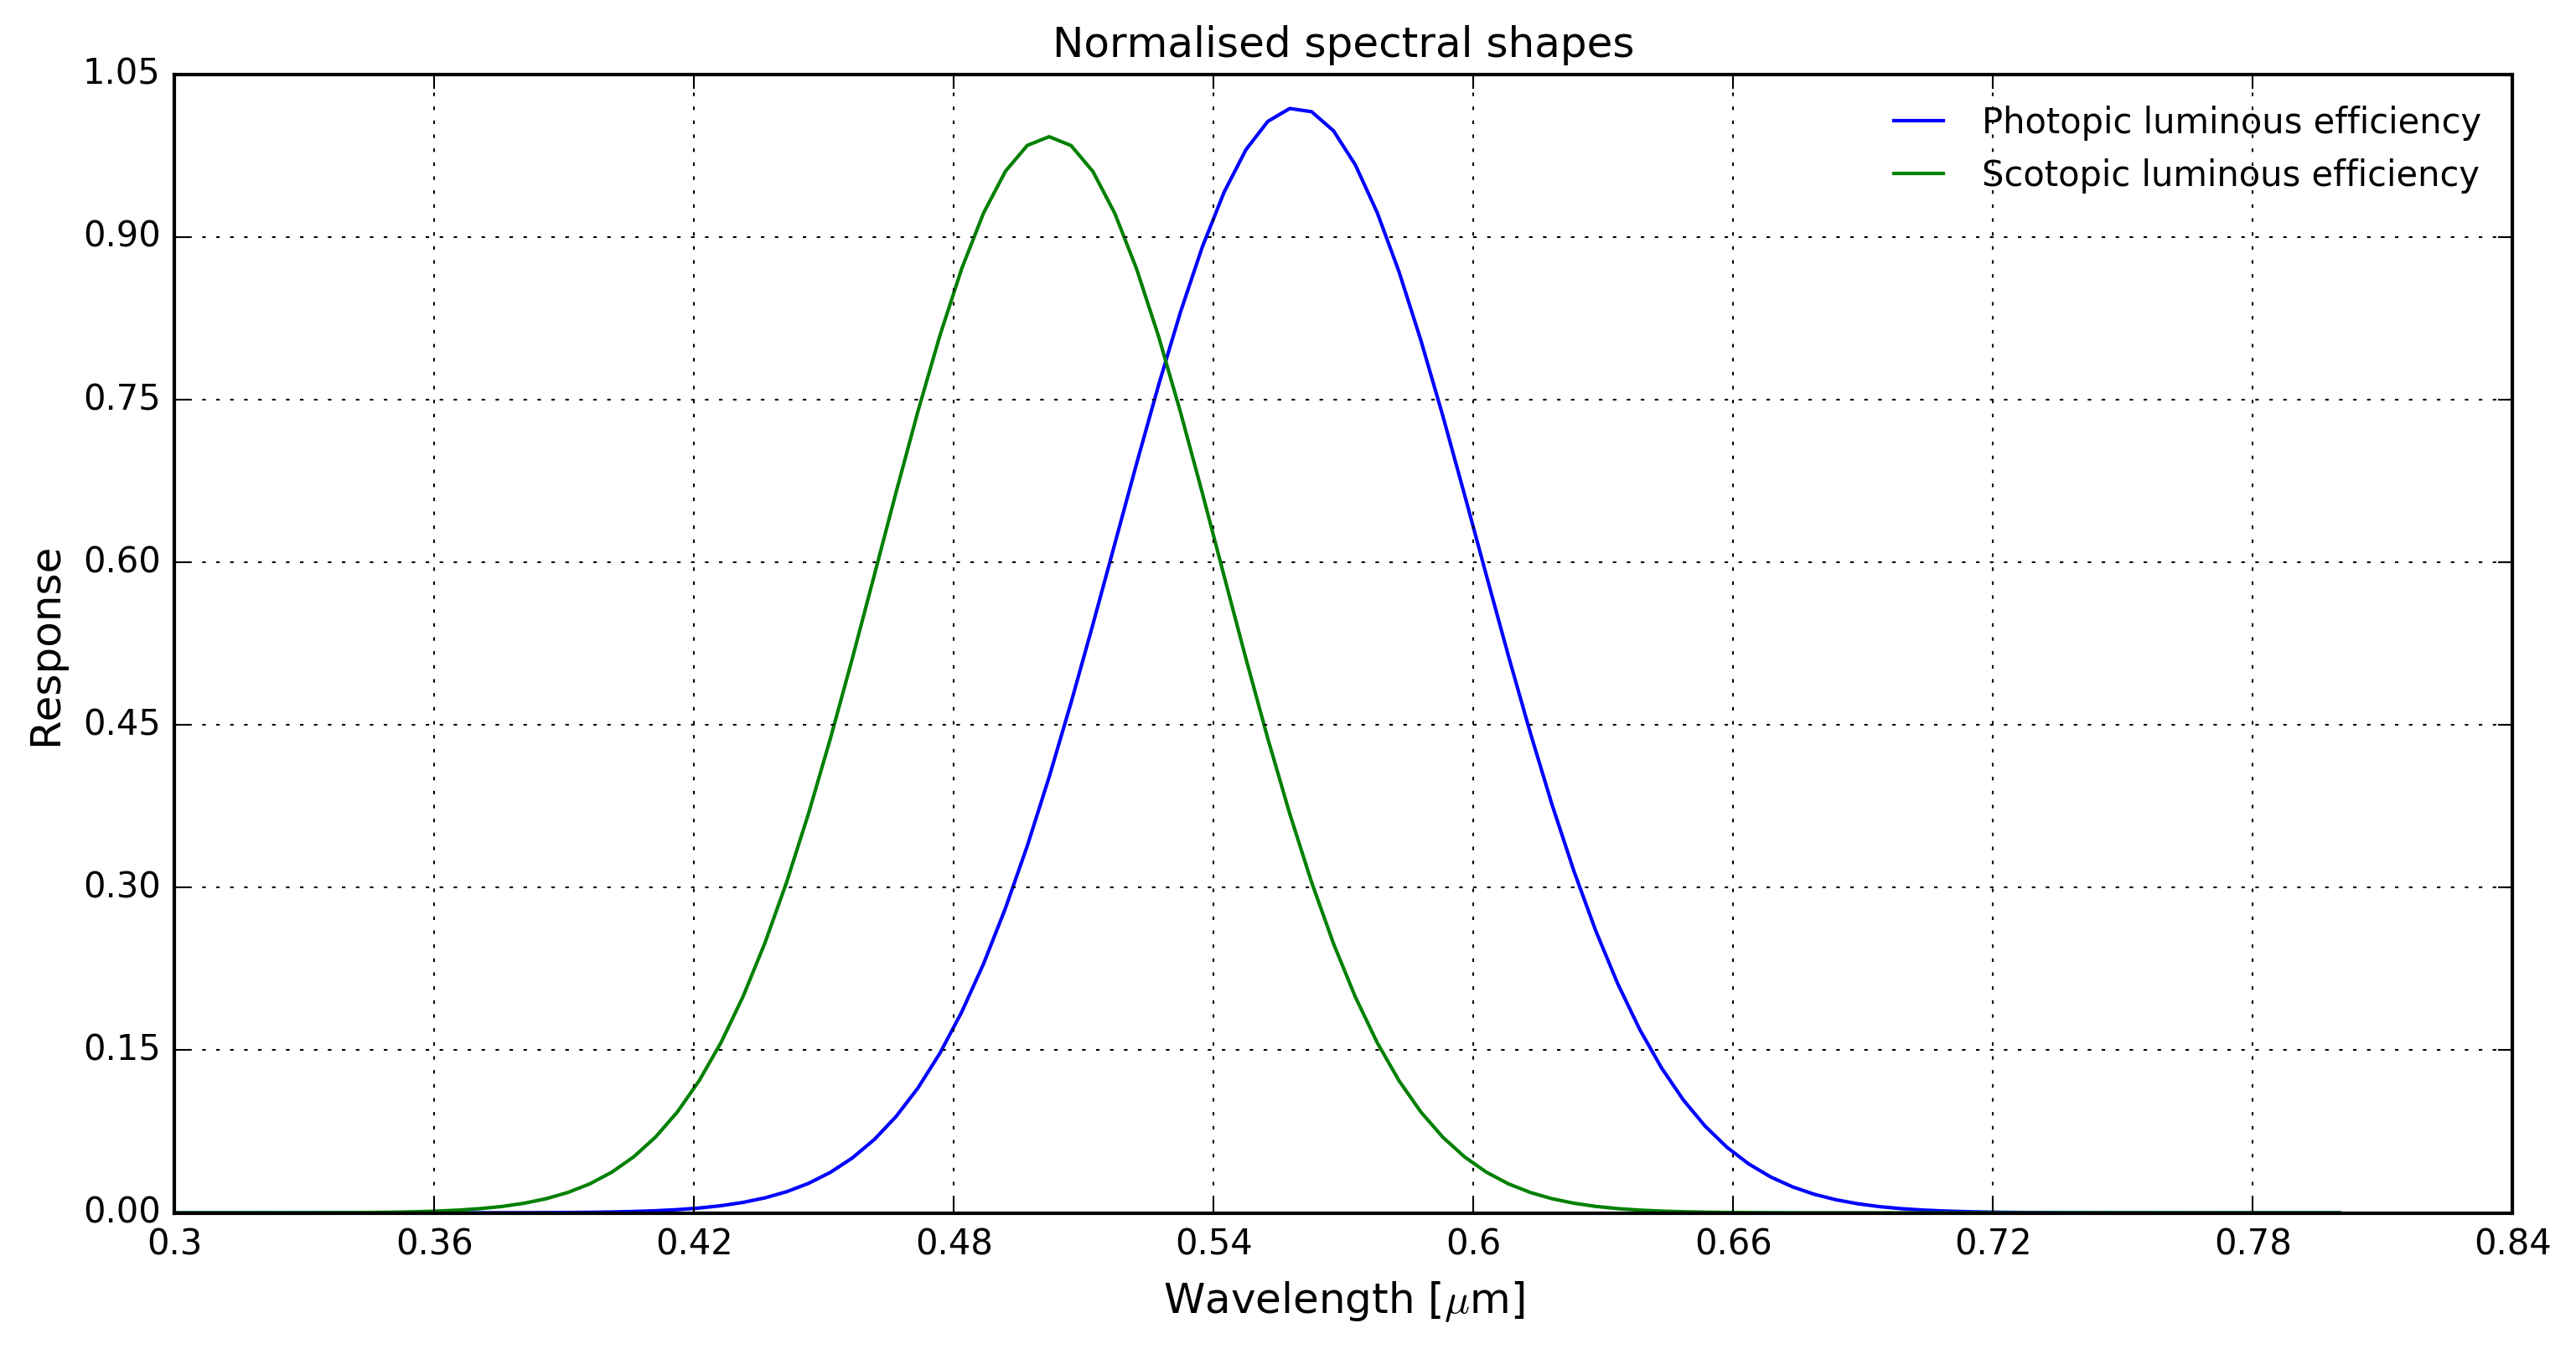

In [4]:
wl = np.linspace(0.3, 0.8, 100)
photLumEff = 1.019 * np.exp(-285.51 * (wl - 0.5591) ** 2 ).reshape(-1,)
scotLumEff = 0.99234 * np.exp(-321.1 * (wl - 0.502) ** 2 ).reshape(-1,)
# mesoLumEff = (photLumEff + scotLumEff) / 2.
# mesoLumEff /= np.max(mesoLumEff)

p = ryplot.Plotter(1,1,1,figsize=(12,6));
p.plot(1,wl,photLumEff , label=['Photopic luminous efficiency']);
# p.plot(1,wl,mesoLumEff , label=['Mesoopic luminous efficiency']);
p.plot(1,wl,scotLumEff , "Normalised spectral shapes","Wavelength [$\mu$m]",
            "Response", label=['Scotopic luminous efficiency']);


The photopic luminance of a source is defined as
\begin{equation}
L_\nu=\int_0^\infty K_{\rm max} V_\lambda L_{e\lambda}(T) d \lambda,
\end{equation}
where
$K_{\rm max}V_\lambda$ is the spectral photopic efficacy,
$V_\lambda$ is the photopic efficiency,
$K_{\rm max}=683$ lm/W is the maximum value of photopic
efficacy, referenced to a 2042-K blackbody standard source, and
$L_{e\lambda}$ is the source's  radiance.  

The scotopic  luminance of a source is defined as
\begin{equation}
 L_\nu=\int_0^\infty K_{\rm max}^\prime V_\lambda^\prime L_{e\lambda}(T) d \lambda,
\end{equation}
where
$K_{\rm max}^\prime V_\lambda^\prime$ is the spectral scotopic efficacy,
$V_\lambda^\prime$ is the scotopic efficiency,
$K_{\rm max}^\prime=1700$ lm/W is the maximum value of scotopic
efficacy, referenced to a 2042-K blackbody standard source, and
$L_{e\lambda}$ is the source's  radiance. 

The conversion between photometric and photon rate units is based on the calculation of a scaling factor $k$ given by solving the following equation.  Under strong light conditions the photopic equation should be used, whereas under very dark conditions the scotopic equation should be used.  In the mesopic range a somewhat arbitrary mix of the two is used.


\begin{equation}
 L_{\nu\textrm{table}} = k L_\nu=k\, 
 \left[
f_P K_{\rm max}\int_0^\infty  V_\lambda L_{e\lambda}(T) d \lambda
+
(1-f_P)K_{\rm max}^\prime\int_0^\infty  V_\lambda^\prime L_{e\lambda}(T) d \lambda
 \right]
\end{equation}
where $k$ is the fraction of the expected illuminance given the colour temperature,
and $f_P$ is the fraction of photopic flux (scotopic flux will be fraction $1-f_P$.  
Calculate $k$ for each entry in the table, using the stated luminance $L_\textrm{table}$ and colour temperature $T$.

Subsequently the wideband integrated photon radiance corresponding to the scenarios in the table can be determined from 

\begin{equation}
L_{q} = k\int_0^\infty  L_{q\lambda}(T) d \lambda 
\end{equation}

In the following code we calculate the reflected radiance for a surface with unity reflectance:


In [5]:
# to calculate $k$ and photon flux in different spectral bands

dfPhotRates['k'] = (dfPhotRates['Irradiance-lm/m2']) / (\
                dfPhotRates['FracPhotop'] * 683 * np.trapz(photLumEff.reshape(-1,1) * \
                            ryplanck.planckel(wl, dfPhotRates['ColourTemp']),wl, axis=0)\
                + \
                (1-dfPhotRates['FracPhotop']) * 1700 * np.trapz(scotLumEff.reshape(-1,1) * \
                            ryplanck.planckel(wl, dfPhotRates['ColourTemp']),wl, axis=0))                           \

specranges = {'Visible': [0.43, 0.69], 'NIR': [0.7, 0.9], 'SWIR': [1.0, 1.7]}
# specranges = {'Visible': [0.45, 0.55], 'NIR': [0.8, 0.9], 'SWIR': [1.0, 1.7]}

for specrange in specranges.keys():
    wlsr = np.linspace(specranges[specrange][0],specranges[specrange][1],300 ).reshape(-1,1)
    dfPhotRates['Radiance-q/(s.m2.sr)-{}'.format(specrange)] = (dfPhotRates['k'] /np.pi ) * \
                np.trapz(ryplanck.planck(wlsr, dfPhotRates['ColourTemp'],'ql'),wlsr, axis=0)

dfPhotRates.sort_values(by='Irradiance-lm/m2',inplace=True)
print(dfPhotRates)

                Irradiance-lm/m2  ColourTemp  FracPhotop             k  \
Overcast night            0.0001        5000         0.0  1.599065e-14   
Star light                0.0011        5000         0.2  1.971425e-13   
Quarter moon              0.0108        4150         0.4  6.922429e-12   
Full moon                 0.1080        4150         0.6  7.864240e-11   
Deep twilight             1.0800       10000         0.8  1.883128e-11   
Twilight                 10.8000       10000         1.0  2.580650e-10   
Very dark day           107.0000        7000         1.0  8.257801e-09   
Overcast day           1075.0000        6000         1.0  1.559271e-07   
Full sky light        10752.0000       12000         1.0  1.587536e-07   
Sun light            107527.0000        5700         1.0  1.963843e-05   

                Radiance-q/(s.m2.sr)-NIR  Radiance-q/(s.m2.sr)-Visible  \
Overcast night              1.309029e+11                  1.433858e+11   
Star light                  1.613852e

## Quick validation

Of course these simple checks do not validate all the data points in the table, but they do validate the calculation.


### Starlight irradiance

The report ''Night sky radiometric measurements during follow-on-evaluation testing of AN/PVS-7 (A,B) at Fort Benning, Ga'' R.J. Stefanik, Center for Night Vision and Electro-Optics, AMSEL-NV-TR-0079, AD-A211273, May 1989, published the following spectral starlight irradiance data 

![''](images/starlight-irradiance.png)

As validation check, simply consider the values at 0.5 $\mu$m and 0.8 $\mu$m and convert to SI units and photon rate. Energy per photon $h\nu=hc/\lambda$, in Joule.
$\Phi_q = \Phi_e/(h\nu) = \Phi_e \lambda/(hc)$

1.  At 0.5 $\mu$m starlight has an irradiance of 0.8 pW/(cm$^2$.nm) = 0.8e-05 W/(m$^2$.$\mu$m). This corresponds to a photon rate radiance of 1.67e+12 q/(s.m$^2$.sr) over the spectral width in the subsequent calculation.  This corresponds closely with the values calculated in the model (1.77e+12  q/(s.m$^2$.sr)).

1.  At 0.8 $\mu$m starlight has an irradiance of 2 pW/(cm$^2$.nm) = 2e-05 W/(m$^2$.$\mu$m). This corresponds to a photon rate radiance of 5.144402e+12 q/(s.m$^2$.sr) over the spectral width in the subsequent calculation.  This corresponds to a factor of 3.2 of the values calculated in the model (1.61e+12 q/(s.m$^2$.sr)).


In [18]:
print('Star light radiance in the visible {:e} q/(s.m2.sr)'.format((0.69 - 0.43) * 0.8e-12 * 1e4 * 1e3 *.5e-6 / (np.pi * 3e8 * 6.6e-34)))
print('Star light radiance in the NIR {:e} q/(s.m2.sr)'.format((0.9 - 0.7) * 2e-12 * 1e4 * 1e3 *.8e-6 / (np.pi * 3e8 * 6.6e-34)))
    

Star light radiance in the visible 1.671931e+12 q/(s.m2.sr)
Star light radiance in the NIR 5.144402e+12 q/(s.m2.sr)


### Value of $k$ for direct sunlight

The value for k for direct sunlight is calculated in [W, Section 3.7], and found to be 2.17e-5 (when accounting for units differences), which corresponds well with the value of 1.96e-05 calculated here.  

## Scene radiance

The signal resulting from reflected light from a surface is given in the general form

\begin{equation}
n_{\textrm{scene}}
=
\left(\frac{\pi t_{\textrm{int}} P  A_d }{4F_\#^2}\right)
\int_0^\infty \eta_{\lambda} \tau_{o\lambda}\tau_{f\lambda} \tau_{a\lambda}
 \rho_\textrm{d} L_{q\lambda}
\;d\lambda
\end{equation}
where
$\rho_\textrm{d}$ is the target diffuse reflectance and the remaining symbols were as previously defined.
If $\tau_{o\lambda}\tau_{f\lambda} \tau_{a\lambda} \rho_\textrm{d}$ can be assumed constant over spectral band,
the $L_{q\lambda}$ can be integrated over the spectral band  and the values in the table calculated previously can be used
 
\begin{equation}
n_{\textrm{scene}}
=
\left(\frac{\pi t_{\textrm{int}} P  A_d }{4F_\#^2}\right)
\eta \tau_{o}\tau_{f} \tau_{a}  \rho_\textrm{d} 
\int_0^\infty L_{q\lambda} \;d\lambda
\end{equation}

The solid angle of the f-number cone is $\Omega_{F_\#}=\pi/(4F_\#^2)$, hence the above equation can be written

\begin{equation}
n_{\textrm{scene}}
=
 t_{\textrm{int}} P   
\eta \tau_{o}\tau_{f} \tau_{a}  \rho_\textrm{d} 
A_d\Omega_{F_\#}\int_0^\infty L_{q\lambda} \;d\lambda
\end{equation}

### First principles reflected sunlight
Using the model in [W, Section 3.7] the  reflected light scene-radiance photon count is given by
\begin{equation}
n_{\textrm{scene}}
=
\left(\frac{\pi t_{\textrm{int}} P  A_d }{4F_\#^2}\right)\cdot
\psi \cos\theta
\cdot
\int_0^\infty \eta_{\lambda} \tau_{o\lambda}\tau_{f\lambda} \tau_{a\lambda}
 \epsilon_\textrm{sun}\tau_\textrm{sun} \rho_\textrm{d} L_\textrm{b}(6000 K)
\;d\lambda
\end{equation}
where 
$\psi=2.17\times 10^{-5}$ relates the sun's area and distance to radiance on the ground,
$\epsilon_\textrm{sun}=1$ is the sun emissivity, 
$\tau_\textrm{sun}$  is the atmospheric transmittance from the target to the sun, 
$\rho_\textrm{d}$ is the target diffuse reflectance,
$L_\textrm{b}(6000 K)$ is the Planck-law thermal radiance for a 6000 K source (approximation of the sun's surface temperature), and 
$\cos\theta$ is the cosine of the angle between the target normal vector and the sun.

In [73]:
# to calculate the electron count in the detector from reflected sunlight only
def nEcntSun(wl, tauAtmo, tauSun, tauFilt, tauOpt, quantEff, rhoTarg, cosTarg, 
             inttime, pfrac, detarea, fno,emis=1.0, tmprt=6000.):
    """ Calculate the number of electrons in a detector
    All values in base SI units
    rhoTarg is the target diffuse reflectance
    cosTarg the cosine of the sun incidence angle
    """
    
    L =  emis * tauAtmo * tauFilt * tauOpt * tauSun * quantEff * \
            rhoTarg * ryplanck.planck(wl, tmprt, type='ql')/np.pi
    L = np.trapz( L, x=wl,axis=0)
    n = np.pi * inttime * pfrac * detarea * L * 2.17e-5 * cosTarg / (4 * fno**2)
    return n

### Low light radiance

The approximate low light level scene radiance levels were calculated above and stored in the `dfPhotRates` DataFrame.  These values are already integrated over the spectral bandwidth, so the scene radiance becomes
 
\begin{equation}
n_{\textrm{scene}}
=
\left(\frac{\pi t_{\textrm{int}} P  A_d \cos\theta}{4F_\#^2}\right)
 \eta \tau_{o}\tau_{f} \tau_{a}  \rho_\textrm{d} 
 L_{q\,dfPhotRates} 
\end{equation}

In [74]:
# to print the available scenarios and spectral bands in the dfPhotRates table
print(dfPhotRates.columns) 
print(dfPhotRates.index) 


Index([u'Irradiance-lm/m2', u'ColourTemp', u'FracPhotop', u'k',
       u'Radiance-q/(s.m2.sr)-NIR', u'Radiance-q/(s.m2.sr)-Visible',
       u'Radiance-q/(s.m2.sr)-SWIR'],
      dtype='object')
Index([u'Overcast night', u'Star light', u'Quarter moon', u'Full moon',
       u'Deep twilight', u'Twilight', u'Very dark day', u'Overcast day',
       u'Full sky light', u'Sun light'],
      dtype='object')


In [75]:
# to calculate the scene electron count from the low light table
def nEcntLLight(tauAtmo, tauFilt, tauOpt, quantEff, rhoTarg, cosTarg, 
             inttime, pfrac, detarea, fno, scenario, specBand):
    """ Calculate the number of electrons in a detector
    All values in base SI units
    rhoTarg is the target diffuse reflectance
    cosTarg the cosine of the sun incidence angle
    scenario must be one of the dfPhotRates index values
    specBand must be one of the dfPhotRates column values
    """
    
    L =  quantEff * tauOpt * tauFilt *  tauAtmo * \
            rhoTarg * dfPhotRates.ix[scenario][specBand]
    n = np.pi * inttime * pfrac * detarea * L * cosTarg / (4 * fno**2)
    return n

### Thermal self-emission

The thermal scene-radiance photon count is given by
\begin{equation}
n_{\textrm{scene}}
=
\left(\frac{\pi t_{\textrm{int}} P  A_d }{4F_\#^2}\right)\cdot
\int_0^\infty \eta_{\lambda} \tau_{o\lambda}\tau_{f\lambda} \tau_{a\lambda}
\epsilon_{\textrm{background}\lambda} L_\lambda(T_\textrm{background})
d\lambda
\end{equation}
where
$t_{\textrm{int}}$ is the integration time,
$P$ is the fraction of clear aperture, 
$A_d$ is the detector area, 
$F_\#$ is the f-number, 
$\eta_{\lambda}$ is the detector quantum efficiency,
$\tau_{o\lambda}$ is the optics transmittance, 
$\tau_{f\lambda}$ is the sensor filter transmittance, 
$\tau_{a\lambda}$ is the atmospheric transmittance, 
$\epsilon_{\textrm{background}\lambda}$ is the background emissivity, and 
$L_\lambda(T_\textrm{background})$ the Planck radiation at background temperature.



In [76]:
# to calculate the electron count in the detector from a thermal source only
def nEcntThermalScene(wl, tmptr, emis, tauAtmo, tauFilt, tauOpt, quantEff, inttime, pfrac, detarea, fno):
    """ Calculate the number of electrons in a detector
    All values in base SI units
    """
    
    L = emis * tauAtmo * tauFilt * tauOpt * quantEff * \
            ryplanck.planck(wl, tmptr, type='ql')/np.pi
    L = np.trapz( L, x=wl,axis=0)
    n = np.pi * inttime * pfrac * detarea * L / (4 * fno**2)
    return n

### Hot optics radiance

For infrared sensors the thermal hot-optics photon count is given by 
\begin{equation}
n_{\textrm{optics}}
=
\left(\frac{\pi t_{\textrm{int}} P  A_d }{4F_\#^2}\right)\cdot
\int_0^\infty \eta_{\lambda} \tau_{f\lambda} 
(1-\tau_{o\lambda}) L_\lambda(T_\textrm{optics})
d\lambda
\end{equation}
where
the optics emissivity is given by
$\epsilon_{\textrm{optics}\lambda}=(1-\tau_{o\lambda})$.
                                          


Assuming no stray light in the visual system, the visual optics photon count is given by 
\begin{equation}
n_{\textrm{optics}}=0
\end{equation}
                                          

In [77]:
# to calculate the electron count in the detector from a thermal source only
def nEcntThermalOptics(wl, tmptrOpt, tauFilt, tauOpt, quantEff, inttime, pfrac, detarea, fno):
    """ Calculate the number of electrons in a detector
    All values in base SI units
    """
    
    L = tauFilt * (1.0 - tauOpt) * quantEff * \
            ryplanck.planck(wl, tmptrOpt, type='ql')/np.pi
    L = np.trapz( L, x=wl,axis=0)
    n = np.pi * inttime * pfrac * detarea * L / (4 * fno**2)
    return n

### Comparison of electron count contributions from different sources

The following code evaluate typical detector charge well electron counts from different sources, using typical sensor values.  These calculations assume infinitely large charge well capacities.  Any real sensor has a finite sized well capacity and the number of electrons should be limited to this well capacity.

In [115]:
# to evaluate typical electron count from different contributors

tauAtmo = 1
tauSun = 0.5
tauFilt = 1.
tauOpt = 0.8
quantEff = 0.7
rhoTarg = .3
cosTarg = 1.
inttime = 0.02
pfrac = 1.0
detarea = (10e-6)**2
fno = 2.
tmptr = 300.
tmptrOpt = 300.
emisscene = .8

scenarios =  [u'Overcast night', u'Star light', u'Quarter moon', u'Full moon',
       u'Deep twilight', u'Twilight', u'Very dark day', u'Overcast day',
       u'Full sky light', u'Sun light']
specBand = u'Radiance-q/(s.m2.sr)-Visible'

for wl, specBand in zip([np.linspace(0.3, 0.8, 100), np.linspace(3.5, 4.8, 100)],
                        [u'Radiance-q/(s.m2.sr)-Visible','Radiance-q/(s.m2.sr)-MWIR']):

    print('\n{}\n{}: electrons in charge well'.format(34*'-',specBand[specBand.rfind('-')+1:]))
    if specBand in dfPhotRates.columns.values:
        print(' ')
        for scenario in scenarios:
            ncnt = nEcntLLight(tauAtmo, tauFilt, tauOpt, quantEff, rhoTarg, cosTarg, 
                     inttime, pfrac, detarea, fno, scenario, specBand)
            print('{:18s} {:.2e}'.format(scenario,ncnt))


    ncnt = nEcntSun(wl, tauAtmo, tauSun, tauFilt, tauOpt, quantEff, rhoTarg, cosTarg, 
                 inttime, pfrac, detarea, fno)
    print('\nDirect sun         {:.2e}'.format(ncnt))

    ncnt = nEcntThermalScene(wl, tmptr, emisscene, tauAtmo, tauFilt, tauOpt, quantEff, inttime, 
                             pfrac, detarea, fno)
    print('Scene termal       {:.2e}'.format(ncnt))

    ncnt = nEcntThermalOptics(wl, tmptrOpt, tauFilt, tauOpt, quantEff, inttime, pfrac, 
                              detarea, fno)
    print('Hot optics thermal {:.2e}'.format(ncnt))



----------------------------------
Visible: electrons in charge well
 
Overcast night     9.46e-03
Star light         1.17e-01
Quarter moon       1.44e+00
Full moon          1.64e+01
Deep twilight      1.64e+02
Twilight           2.24e+03
Very dark day      2.19e+04
Overcast day       2.20e+05
Full sky light     2.25e+06
Sun light          2.20e+07

Direct sun         2.60e+07
Scene termal       3.31e-14
Hot optics thermal 1.03e-14

----------------------------------
MWIR: electrons in charge well

Direct sun         2.50e+06
Scene termal       5.10e+06
Hot optics thermal 1.59e+06


## Signal model

The [G] model calculates the signal and noise components from primary sensor parameters, allowing for the sensor MTF.  The model describes the noise equivalent temperature or noise equivalent reflectance in terms of spatial frequency and then solves for the noise equivalent terms in terms of spatial frequency.

The sensor's perceived signal to noise ratio when imaging a square wave bar target
in the presence of sensor noise is given by

\begin{equation}
\textrm{SNR} = \frac{\textrm{CTF}(\xi) \cdot [n_{\textrm{signal}} - n_{\textrm{background}}] }{n_{\textrm{noise}}}
\end{equation}
where 
$\textrm{SNR}$ is the signal to noise ratio, 
$\textrm{CTF}(\xi)$ is the sensor's contrast transfer function, 
$\xi$ is spatial frequency,
$n_{\textrm{signal}}$ is the signal electron count in the detector, 
$n_{\textrm{background}}$ is the background electron count in the detector, and 
$n_{\textrm{noise}}$ is the sensorn noise at the sensor output.  The signal as defined here is the signal in one pixel. 


Using a variation of the camera equation (Equation 9.56 in [W]) the electron count in the detector from a source contrast radiance $\Delta L$ is given by the flux on the detector multiplied by the quantum efficiency and the integration time:

\begin{equation}
\Delta n_{\textrm{det}\; \lambda}
=
\frac{\pi \eta_{\lambda} t_{\textrm{int}} P K_N(\alpha) A_d \tau_{o\lambda}\tau_{f\lambda} \tau_{a\lambda}\left[L_{\textrm{signal}\lambda}- L_{\textrm{background}\lambda}\right] \cos^4\alpha}{4F_\#^2(1+|m|)^2},
\end{equation}
where
$\eta_{\lambda}$ is the detector spectral quantum efficiency,
$t_{\textrm{int}}$ is the detector integration time, 
$P$ an efficiency factor accounting for a central obscuration (if present), 
$K_N(\alpha)$  is the vignetting losses (if present),
$A_d$ is the area of the detector, 
$\tau_{o\lambda}$ is the optics transmittance, 
$\tau_{f\lambda}$ is the spectral filter transmittance, 
$\tau_{a\lambda}$ is the atmospheric transmittance, 
$L_{\textrm{signal}\lambda} = \epsilon_\textrm{signal} L_\lambda(T_\textrm{signal})$ is the signal source radiance,
$L_{\textrm{background}\lambda} = \epsilon_\textrm{background} L_\lambda(T_\textrm{background})$ is the background source radiance,
$\cos^4\alpha$ is the cosine-to-the-fourth losses,
$\alpha$ is the field angle,
$F_\#$ is the sensor f-number, and
$m$ is the magnification.


At inifinte conjugates $m$=0, with on-axis viewing $\alpha$=0, with no vignetting $K_N(\alpha)$=0, the camera equation for target contrast becomes

\begin{equation}
\Delta n_{\textrm{det}}
=
\left(\frac{\pi t_{\textrm{int}} P  A_d }{4F_\#^2}\right)\cdot
\int_0^\infty \eta_{\lambda} \tau_{o\lambda}\tau_{f\lambda} \tau_{a\lambda}\left[L_{\textrm{signal}\lambda}- L_{\textrm{background}\lambda}\right] d\lambda
\end{equation}



Rejoining [G] we define the noise equivalent quanta as the the contrast quantum signal where the signal to noise is equal to one.  In keeping with [W] notation noise equivalent quanta is written as NEQ. Then 

\begin{equation}
\textrm{NEQ} = \frac{n_{\textrm{noise}}}{\textrm{CTF}(\xi)} = 
\left(\frac{\pi t_{\textrm{int}} P  A_d }{4F_\#^2}\right)\cdot
\int_0^\infty \eta_{\lambda} \tau_{o\lambda}\tau_{f\lambda} \tau_{a\lambda}\left[L_{\textrm{signal}\lambda}- L_{\textrm{background}\lambda}\right] d\lambda
\end{equation}



From [G]: If we assume the square wave response of the sensor is band-limited and that for the higher spatial
frequencies only the fundamental of the square wave has sufficient response, then the amplitude conversion from the square wave $\textrm{CTF}$ to the sinusoid modulation transfer function, $\textrm{MTF}$, is a factor $4/\pi$

\begin{equation}
\textrm{CTF}(\xi) \approx \frac{4}{\pi}\textrm{MTF}(\xi)
\end{equation}


After manipulation we arrive at Equation 7 in [G]:

\begin{equation}
\pi\int_0^\infty \eta_{\lambda} \tau_{o\lambda}\tau_{f\lambda} \tau_{a\lambda}\textrm{LEQ}_\lambda d\lambda
=
\frac{\pi F_\#^2 n_{\textrm{noise}}}{ t_{\textrm{int}} P  A_d\textrm{MTF}(\xi)} 
\end{equation}
with units of q/(s$\cdot$m$^2$), and 
where 
$\textrm{LEQ}_\lambda = L_{\textrm{signal}\lambda}- L_{\textrm{background}\lambda}$ is understood to be the contrast radiance between two pixels that provides a signal to noise ratio of one.


**Thermal sources:** Expanding on Section 9.5.4 in [W] that for small temperature differences, the noise equivalent temperature difference for a thermal source can be approximated by

\begin{equation}
\frac{\textrm{LEQ}}{\textrm{NETD}} = \frac{dL}{dT} = \int_0^\infty \eta_{\lambda} \tau_{o\lambda}\tau_{f\lambda} \tau_{a\lambda}
\left(
\frac{L_\lambda(T_{\textrm{background}})}{dT}
\right)
d\lambda
\end{equation}



Hence for thermal sources a form similar to Equation 9 in [G] is derived

\begin{equation}
 \textrm{NETD}
=
\frac{ F_\#^2]\, n_{\textrm{noise}}}{ t_{\textrm{int}} P  A_d\textrm{MTF}(\xi)\left[ \int_0^\infty \eta_{\lambda} \tau_{o\lambda}\tau_{f\lambda} \tau_{a\lambda}
\left(
\frac{L_\lambda(T_{\textrm{background}})}{dT}
\right)
d\lambda\right]} 
\end{equation}


**Reflective sources:** Similarly to the thermal source derivation,  for target reflection differences, the noise equivalent reflection difference for a reflective source can be approximated by

\begin{equation}
\frac{\textrm{LEQ}}{ \textrm{NE}\rho} = \frac{dL}{d\rho} = \int_0^\infty \eta_{\lambda} \tau_{o\lambda}\tau_{f\lambda} \tau_{a\lambda}
L_{\textrm{source}\lambda}
d\lambda
\end{equation}



Hence for reflective sources we derive an equation similar to Equation 7 in [G]:

\begin{equation}
 \textrm{NE}\rho
=
\frac{ F_\#^2\, n_{\textrm{noise}}}{ t_{\textrm{int}} P  A_d\textrm{MTF}(\xi) \int_0^\infty \eta_{\lambda} \tau_{o\lambda}\tau_{f\lambda} \tau_{a\lambda}
L_{\textrm{source}\lambda}
d\lambda} 
\end{equation}


## Noise model

![''](images/camerascheme-horiz-labelled.png)


The [G] model includes photon noise and fixed pattern non-uniformity noise.  However for low light level work a more comprehensive noise model, such as Konnik's model, is required.
The components of the noise model include 

1. Photon signal noise (present in [G] model).
2. Detector response non-uniformity (present in [G] model).
3. Dark current shot noise.
4. Fixed pattern dark current noise.
5. Read noise also known as kTC reset noise.
6. Source follower noise.
7. Quantisation noise.

If the magnitudes of these noise components are not available, we can just assume zero values to ignore these.

The various noise sources are assumed non-correlated and add in quadrature (with apropriate gain scaling).


### Photon noise 

Photon noise for a flux signal is given by the square root of the signal photon count.  The signal photon count comprises photons from the scene (target and background temperatures assumed to the more or less the same), photons from inside the sensor such as hot optics (other sources ignored for now), and atmosperic path radiance.   On the assumption that the atmospheric path temperature is close to the scene temperature the path radiance plus attenuated scene radiance would be more or less equal to the unattenuated scene radiance, i.e., $L_\textrm{path} + \tau_\textrm{path} L_\textrm{scene}\approx L_\textrm{scene}$.

Photon noise is casused by the photon signal itself.  The photon signal in the detector comprises the following components:

1. Reflected incident light such as sunlight, sky light or night light.
1. Thermal self-emission.
1. Stray light and internal sensor flux sources.



The total photon flux is
\begin{equation}
n_{\textrm{photons}} = n_{\textrm{scene}} + n_{\textrm{optics}}
\end{equation}

The photon noise is then 

\begin{equation}
n_{\textrm{photnoise}} =\sqrt{n_{\textrm{photons}}} =  \sqrt{n_{\textrm{scene}} + n_{\textrm{optics}}}
\end{equation}

### Non-uniformity noise 

From [G] and [Konnik]

1. The non-uniformity noise vir visual CCD and CMOS sensors is a gaussian noise with standard deviation $n_{\textrm{NU}}$ given by  $U=n_{\textrm{NU}}/n_{\textrm{photons}}$, with $U$ less than or equal to  1% for CCD and 5% for CMOS sensors.

2. The non-uniformity noise for infrared sensors has the form 
$n_{\textrm{NU}}\leq \left(\sqrt{n_{\textrm{photons}}}\right)^{-1}$


### Dark current shot noise

The average dark current electron count is given by 

\begin{equation}
n_{\textrm{darkcurrent}} = t_I\cdot 2.55\cdot10^{15}A_d D_{FM} T^{1.5} \exp\left[-\frac{E_{gap}}{2 k T}\right]
\end{equation}
where:
$t_I$ is the integration time,
$A_d$ is the pixel's area [cm$^2$],
$D_{FM}$ is the dark current figure-of-merit in units of [nA/cm$^2$] at 300K (varies significantly
with sensor manufacturer, typical value is 0.5 nA/cm$^2$ for Si detectors),
$E_{gap}$ is the bandgap energy of the semiconductor which varies with temperature,
$k$ is Boltzman's constant that is $8.617\cdot10^{-5}$ [eV/K].
It appears that fill factor does not apply to dark current.
The bandgap for a photon detector is roughly $1.24/\lambda_c$ where $\lambda_c$ is the detector cutoff wavelength.  The bandgap for commonly used detectors at 300 K are 
Si:1.11 eV, 
Ge:0.66 eV,  
GaAs:1.43 eV,  
InP:1.27 eV, 
and at 77 K InSb:0.24 eV.

Dark current causes shot noise (a Poisson signal) so that the dark current noise is 

\begin{equation}
n_{\textrm{darkcurrentnoise}} = \sqrt{n_{\textrm{darkcurrent}}}
\end{equation}


This model is taken from [here](http://nelisw.github.io/pyradi-docs/_build/html/rystare.html#pyradi.rystare.dark_current_and_dark_noises).


In [8]:
# to calculate the dark current noise   
def darkcurrentnoise(inttime, detarea,temptr, Egap, DFM=0.5e-5):
    """Note that DFM is in units of nA/m2
    """
    ndarkcur = inttime * 2.55e15 * detarea * DFM * (temptr ** 1.5) * np.exp(-Egap/(2 * 8.617e-5 * temptr) )
    
    return np.sqrt(ndarkcur)


### Fixed pattern dark current noise

Fixed pattern dark noise is not considered here because of the relatively short integration times (compared to astronomy sensors).

### Read noise also known as kTC reset noise

kTC noise results from random fluctuations of charge on the sense node during the reset stage, resulting in a corresponding photodiode reset voltage fluctuation.   In CCD sensors the sense node reset noise is removed by Correlated Double Sampling (CDS).
In CMOS photosensors, it is difficult to remove the reset noise even after application of CDS. Specifically, the difficulties arise in 'rolling shutter' and 'snap' readout modes.  Elimination of reset noise in CMOS is quite challenging.
The magnitude of the sense node read noise in electrons is given by 
\begin{equation}
n_{\textrm{kTCnoise}}=\frac{\sqrt{k_B T C_{SN}}}{q}
\end{equation}
where
$q$ is the charge of an electron,
$k_B$ is the Boltzmann constant, 
$T$ is the temperature, and 
$C_{SN}$ is the sense node capacitance.
For this investigation the noise is assumed gaussian distributed.


In [ ]:
# to calculate the kTC noise 

### Source follower noise
Source follower noise is ignored in this study.

### Quantisation noise
Quantisation follower noise is ignored in this study.

### Total noise

The total noise  is then given by

\begin{equation}
n_{\textrm{noise}} = \sqrt{n_{\textrm{photnoise}}^2+ n_{\textrm{NU}}^2 + n^2_{\textrm{darkcurrentnoise}} + n^2_{\textrm{kTCnoise}}}
\end{equation}

For visual band sensors (corresponding to Equation 10 in [G])
\begin{equation}
n_{\textrm{noise}} = \sqrt{n_{\textrm{photnoise}}^2+ (U n_{\textrm{photons}})^2 + n^2_{\textrm{darkcurrentnoise}} + n^2_{\textrm{kTCnoise}}}
\end{equation}


For infrared sensors
\begin{equation}
n_{\textrm{noise}} 
= \sqrt{n_{\textrm{photnoise}}^2+ \left(\sqrt{n_{\textrm{photons}}}\right)^{-2} + n^2_{\textrm{darkcurrentnoise}} + n^2_{\textrm{kTCnoise}}}
\end{equation}
\begin{equation}
n_{\textrm{noise}} 
= \sqrt{n_{\textrm{photons}}+ n_{\textrm{photons}}^{-1} + n^2_{\textrm{darkcurrentnoise}} + n^2_{\textrm{kTCnoise}}}
\end{equation}



## MTF components

### Detector MTF

The detector MTF is modelled as a `sinc` function

\begin{equation}
MTF_{\textrm{det}} = \textrm{sinc}\left( \pi\xi \alpha\right)= \textrm{sinc}\left(  \frac{\pi\xi\beta}{f}\right)
\end{equation}

where 
$\xi$ is spatial frequency in cy/rad, and 
$\alpha$ is the detector angular size in rad,
$\beta$ is the detector size in meters,
$f$ is the focal length in meters.  

The dimensional analysis of the argument is not immediately evident: one detector subtends half a cycle and this must be accounted for in the dimensional analysis:

\begin{equation}
\left[\frac{\textrm{rad}}{1}\right]
\left[\frac{\textrm{cy}}{\textrm{rad}}\right]
\left[\frac{\textrm{rad}}{\textrm{pix}}\right]
\left[\frac{\textrm{pix}}{\textrm{cy}}\right]
\rightarrow 
\left[\frac{\textrm{rad}}{1}\right]
\left[\frac{\textrm{cy}}{\textrm{rad}}\right]
\left[\frac{\textrm{m}}{\textrm{pix}}\right]
\left[\frac{\textrm{pix}}{\textrm{cy}}\right]
\left[\frac{\textrm{1}}{\textrm{m}}\right]
\rightarrow 
\textrm{rad}
\end{equation}

Note: the numpy sinc function already includes a $\pi$ in the function code, don't add it in your code!!!

In [ ]:
# to calculate detector MTF
def MTFdetector(freq, pixsize, foclen):
    # freq in cy/rad
    # pixsize in m
    # foclen in m
    return np.sinc(freq * pixsize  / foclen)

In [ ]:
# to plot detector MTF as function of detector pixel size
p = ryplot.Plotter (1 ,1 ,1 , figsize =(8 ,4) )
if 'MTF detector' not in dfS.index.values:
    dfS = dfS.append(pd.DataFrame(index=['MTF detector']))
ffreqmax = np.max(dfS.loc['SpatFreqMax cy/m'])
for colname in dfS.columns.values:
    ffreq = dfS.loc['SpatFreq cy/m'][colname]
    pixsize = dfS.loc['Pixel size'][colname]
    dfS.loc['MTF detector'][colname] = MTFdetector(ffreq,pixsize,foclen)
    p.plot(1, ffreq/1000., np.abs(dfS.loc['MTF detector'][colname]),
           r'Horizontal and vertical detector MTF','Frequency cy/mm','MTF',
           label=[r'{} {} $\mu$m pixel size'.format(colname, pixsize*1e6)],
           pltaxis =[0,ffreqmax/1000.,-0,1]);

### Optics aberration MTF

From [G], the optics aberration can be modelled by the generic function

\begin{equation}
MTF_\textrm{opt}
= 
\exp
\left[
-2\left(
\frac{\pi \sigma_\textrm{d}\xi}{\xi_0}
\right)^2\right]
= 
\exp
\left[
-2\left(
\frac{\pi \sigma_\textrm{d}\xi\lambda}{D}
\right)^2\right]
\end{equation}
where
$\sigma_\textrm{d}$ is the spot size factor,
$\xi$ is spatial frequency in cy/m,
$\xi_0$ is cutof or critical spatial frequency in cy/m,
$\lambda$ is the mean wavelength, and
$D$ is the aperture diameter in m.



 The units of the square root of the argument are 
 
\begin{equation}
\left[\frac{\textrm{rad}}{\textrm{1}}\right]
\left[\frac{\textrm{m}}{\textrm{m}}\right]
\left[\frac{\textrm{cy}}{\textrm{rad}}\right]
\left[\frac{\textrm{rad}}{\textrm{cy}}\right]
\rightarrow 
\textrm{rad}
\rightarrow 
\left[\frac{\textrm{m}}{\textrm{m}}\right]
\rightarrow 
\textrm{1}
\end{equation}

and

\begin{equation}
\left[\frac{\textrm{rad}}{\textrm{1}}\right]
\left[\frac{\textrm{m}}{\textrm{m}}\right]
\left[\frac{\textrm{cy}}{\textrm{rad}}\right]
\left[\frac{\textrm{m}_{\lambda}}{\textrm{1}} \right]
\left[\frac{\textrm{1}}{\textrm{m}_\textrm{d}} \right]
\rightarrow 
\left[\frac{\textrm{m}}{\textrm{m}}\right]
\rightarrow 
\textrm{1}
\end{equation}


In [ ]:
# to calculate aberration MTF
def MTFaberation(freq, sratio, freqo):
    # freq in cy/rad
    # spot size factor
    # cutof freq in cy/mrad
    return np.exp(-2. * (np.pi * sratio * freq / freqo) ** 2)

In [ ]:
# to calculate the MTF of diffraction through a circular aperture
def MTFcirc(freq):
    f = np.abs(freq / np.max(freq))
    return 2. * ( np.arccos(f) - f * np.sqrt(1-f**2)) / np.pi

In [ ]:
# to plot the aberration MTF as function of spot size factor
p = ryplot.Plotter (1 ,1 ,1 , figsize =(8,4) )
if 'MTF aberration' not in dfS.index.values:
    dfS = dfS.append(pd.DataFrame(index=['MTF aberration']))

ffreqmax = np.max(dfS.loc['SpatFreqMax cy/m'])
for colname in dfS.columns.values:
    ffreq = dfS.loc['SpatFreq cy/m'][colname]
    sratio= dfS.loc['Aberration size factor'][colname]
    dfS.loc['MTF aberration'][colname] = MTFaberation(ffreq, sratio, dfS.loc['SpatFreqMax cy/m'][colname])
    
    p.plot(1, ffreq/1000.,dfS.loc['MTF aberration'][colname], 
           r'Aberration MTF approximation','Frequency cy/mm','MTF',
           label =[r'{}: {} spot size factor'.format(colname,sratio)], 
           pltaxis =[0,ffreqmax/1000.,-0,1]) ;   

### Diffraction MTF

The optical transfer function is the Fourier transform of the point spread function, and the point spread function is the square absolute of the inverse Fourier transformed pupil function. The optical transfer function can also be calculated directly from the pupil function. From the convolution theorem it can be seen that the optical transfer function is  the auto-correlation of the pupil function <https://en.wikipedia.org/wiki/Optical_transfer_function>.  If an image of the pupil function is known the  diffraction MTF of the pupil can be calculated numerically.

The fractional clear aperture and area of the sensor are calculated by simply counting the number of pixels in the clear aperture (accounting for the fact that the aperture is circular, not square as is the image).  The MTF is calculated using the SciPy two-dimensional correlation function `signal.correlate2d`.

In this calculation the MTF for a clear aperture and centrally obscured aperture is calculated, both of which have closed form analytical equations. The advantage of calculating the MTF from the pupil function is that any shape aperture can be used; just create an image of the pupil. The calculation takes a long time to calculate for large images, so the image can be subsampled to the required degree of accuracy.

In the MTF calculations below the MTF of a round aperture is calculated in square image coordinates. When the frequency scale is calculated, the distance to the corner of the image determines the full scale frequency of the calculation.  This full scale frequency is an artifact of the calculation, and is not the aperture cutof frequency that has optical meaning.  The full scale frequency is given by 

\begin{equation}
\xi_\textrm{fs} = \frac{\sqrt{2} D}{\lambda f}
\end{equation}

where the $\sqrt{2}$ accounts for the distance to the corner (relative to the round aperture diameter), 
$D$ is the aperture diameter,
$\lambda$ is the wavelength, and 
$f$ is the distance to the screen (e.g., focal length).

Then the optical cutof frequency or critical frequency is given by

\begin{equation}
\xi_0 = \xi_\textrm{fs}/\sqrt{2} = \frac{ D}{\lambda f}
\end{equation}

The calculation below was performed for a screen/focal distance of 1 m.  This essentially means that the units of $\xi_0$ is cycles/rad.  The spatial frequency in cycles/m for any focal length $f$ can then be found as 
$\xi_\textrm{cycles/m} = \xi_\textrm{cycles/rad}/f$



In [ ]:
# to calculate the autocorrelation and clear area and write to file
# this function may take a long time to execute
def pupilautocor(PIK, dOptics, sampling = 5):

    fracclear = {}
    areasens = {}
    pupil = {}
    corrn = {}
    polar_corrn = {}
    polar_radius = {}
    meanmtf = {}
    
    for i,mtflabel in enumerate(dOptics.keys()):
        filename = dOptics[mtflabel]['Pupil']
        print(mtflabel,filename)

        #read the mask image
        pup = ndimage.imread(filename).astype(float)
        #make binary image
        pup[...,-1] = np.where(pup[...,-1]>0, 1.0, 0.0)
        #area-circle=pi*r^2, area-square=4*r^2, ratio=pi/4
        fracclear[mtflabel] = (4. / np.pi) * np.sum(pup[...,-1])/(pup[...,-1].shape[0]*pup[...,-1].shape[1])

        # slice, cut out one plane and exact size
        pupil[mtflabel] = pup[::sampling,0:pup.shape[0]:sampling,3] 
        #http://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.signal.correlate2d.html
        corr = signal.correlate2d(pupil[mtflabel], pupil[mtflabel], boundary='fill', mode='full')
        corrn[mtflabel] = corr / np.max(corr)

        #do for autocorrelation
        polar_c, _, _ = pim.reprojectImageIntoPolar(corrn[mtflabel].reshape(corrn[mtflabel].shape[0],corrn[mtflabel].shape[1],1), None, False,cval=0.)
        polar_c = polar_c[:,:,0]
        polar_corrn[mtflabel] = polar_c
        #do for radius
        polar_c, _, _ = pim.reprojectImageIntoPolar(pupil[mtflabel].reshape(pupil[mtflabel].shape[0],pupil[mtflabel].shape[1],1), None, False,cval=0.)
        polar_c = np.flipud(polar_c[:,:,0])
        polar_radius[mtflabel] = polar_c

        meanmtf[mtflabel] = polar_corrn[mtflabel].mean(axis=1)
        
    data = (pupil, corrn, pupfn, mtflabels, fracclear, areasens, polar_corrn, polar_radius, meanmtf)
    with open(PIK, "wb") as f:
        pickle.dump(data, f)
                

In [ ]:
# to calculate the mtf

#NOTE!!!!!!!!
# The reprojectImageIntoPolar function maps radial to cartesian coords. 
# The radial image is however presented in a cartesian grid, the corners have no meaning.
# The radial coordinates are mapped to the radius, not the corners.
# This means that in order to map corners, the frequency is scaled with sqrt(2), 
# The corners are filled with the value specified in cval, which must be zero

mtfpclfilename = 'ApertureMTF.pcl'

freqfsm = {}
rho = {}
fcrit = {}

#calculate if not already existing
if not os.path.exists(mtfpclfilename):
    pupilautocor(mtfpclfilename, dOptics, sampling = 5)
    
#load the correlation data from the pickle file
with open(mtfpclfilename, "rb") as f:
    (pupil, corrn, pupfn, mtflabels, fracclear, areasens, polar_corrn, polar_radius, meanmtf) = pickle.load(f)
    
    I = ryplot.Plotter(1,2,4,'', figsize=(8,4));

    for i,mtflabel in enumerate(dOptics.keys()):
        I.showImage(4*i+1, pupil[mtflabel], ptitle=mtflabel, cmap=ryplot.cubehelixcmap(), titlefsize=10,  
                    cbarshow=False);
        I.showImage(4*i+2, polar_radius[mtflabel], ptitle='Unfolded pupil', cmap=ryplot.cubehelixcmap(), titlefsize=10,  
                    cbarshow=False);
        I.showImage(4*i+3, corrn[mtflabel], ptitle='Pupil diffraction MTF', cmap=ryplot.cubehelixcmap(), titlefsize=10,  
                    cbarshow=True, cbarorientation = 'vertical', cbarfontsize = 7);
        I.showImage(4*i+4, polar_corrn[mtflabel], ptitle='Pupil diffraction MTF', cmap=ryplot.cubehelixcmap(), titlefsize=10,  
                    cbarshow=True, cbarorientation = 'vertical', cbarfontsize = 7);
    

p = ryplot.Plotter(2,1,1,'', figsize=(10,4));
if 'MTF diffraction' not in dfS.index.values:
    dfS = dfS.append(pd.DataFrame(index=['MTF diffraction']))
ffreqmax = np.max(dfS.loc['SpatFreqMax cy/m'])
for colname in dfS.columns.values:
    freqfsm = np.sqrt(2.) * dfS.loc['SpatFreqMax cy/m'][colname]
    mtflabel = dfS.loc['MTF label'][colname]
    rho = np.linspace(0,freqfsm,polar_corrn[mtflabel].shape[0]) 
    ffreq = dfS.loc['SpatFreq cy/m'][colname]
    dfS.loc['MTF diffraction'][colname] = np.interp(ffreq, rho,  meanmtf[mtflabel])
    p.plot(1, ffreq/1000.,dfS.loc['MTF diffraction'][colname], 
           r'Diffraction MTF approximation','Frequency cy/mm','MTF',
           label =[r'{}'.format(colname)],pltaxis =[0,ffreqmax/1000.,-0,1]) ;   


### Line of sight movement MTF

Line of sight movement has two effects: (1) linear motion smear of the image during integration time, and (2) random movement blur during integration time.  The two degradation mechanisms have to different effect in the image.

Image degradation attributable to linear smear is modelled as a `sinc` function

\begin{equation}
MTF_{\textrm{smear}} = \textrm{sinc}\left( \pi\xi \dot{\theta} t_i \right)
\end{equation}

where 
$\xi$ is spatial frequency in cy/rad,
$\dot{\theta}$ is linear motion in rad/s, and 
$t_i$ is integration time in s

The units of the argument are 
\begin{equation}
\left[\frac{\textrm{rad}}{\textrm{cy}}\right]
\left[\frac{\textrm{cy}}{\textrm{rad}}\right]
\left[\frac{\textrm{rad}}{\textrm{s}}\right]
\left[\frac{\textrm{s}}{\textrm{1}}\right] \rightarrow \textrm{rad}
\end{equation}

The [G] model does not account for linear smear movement. Experiments have shown that smear results in more degradation than does random noise blur, so perhaps it should be included in the calculation.


Random noise blur is calculated as the 1-$\sigma$ residual random movement of the projected pixel direction after linear smear is removed.

The blur MTF is given by 

\begin{equation}
MTF_{\textrm{blur}} = \exp\left[-2(\pi \sigma_b \xi)^2\right]
\end{equation}
where
where 
$\xi$ is spatial frequency in cy/rad, and
$\sigma_b$ is the 1-$\sigma$ jitter during integration time in rad.


In [ ]:
# to calculate smear MTF
def MTFsmear(freq, smearRate, inttime):
    # freq in cy/rad
    # smearRate in rad/s
    # inttime in s
    return np.sinc(freq * smearRate * inttime)

In [ ]:
# to calculate blur MTF
def MTFblur(freq, rmsblur):
    # freq in cy/rad
    # rmsblur in rad
    return np.exp(-2 * (np.pi * freq  *  rmsblur) ** 2)

In [ ]:
# to plot the smear and blus MTF as function of linear motion and blur.
p = ryplot.Plotter (1 ,1 ,1 , figsize =(8 ,4) )

if 'MTF smear motion' not in dfS.index.values:
    dfS = dfS.append(pd.DataFrame(index=['MTF smear motion']))
if 'MTF blur motion' not in dfS.index.values:
    dfS = dfS.append(pd.DataFrame(index=['MTF blur motion']))
ffreqmax = np.max(dfS.loc['SpatFreqMax cy/m'])
for colname in dfS.columns.values:
    ffreq = dfS.loc['SpatFreq cy/m'][colname]
    rmsblur= dfS.loc['RMS jitter rad'][colname]
    smearRate= dfS.loc['Linear smear rad/s'][colname]
    dfS.loc['MTF smear motion'][colname] = MTFsmear(ffreq, smearRate, inttime)
    dfS.loc['MTF blur motion'][colname] = MTFblur(ffreq, rmsblur)
    p.plot(1, ffreq/1000., dfS.loc['MTF blur motion'][colname],r'Line of sight motion MTF',
     'Frequency cy/mm','MTF',label=[r'{} {} $\mu$m rms blur'.format(colname,rmsblur*1e6)]);
    inttime = 0.01
    p.plot(1, ffreq/1000., dfS.loc['MTF smear motion'][colname],r'Line of sight motion MTF',
     'Frequency cy/mm','MTF',label=[r'{} {} mrad/s smear rate'.format(colname,smearRate*1e3)],
          pltaxis =[0,ffreqmax/1000.,-0,1]);
    

In [ ]:
# to plot the MTF components per sensor
p = ryplot.Plotter (1 ,4 ,1 , figsize =(8 ,12) )

if 'MTF effective' not in dfS.index.values:
    dfS = dfS.append(pd.DataFrame(index=['MTF effective']))
    
for i,colname in enumerate(dfS.columns.values):
    
    ffreq = dfS.loc['SpatFreq cy/m'][colname]
    rmsblur = dfS.loc['RMS jitter rad'][colname]
    smearRate = dfS.loc['Linear smear rad/s'][colname]
    ffreqmax = dfS.loc['SpatFreqMax cy/m'][colname]
    obscuration = dfS.loc['MTF label'][colname]
    
    dfS.loc['MTF effective'][colname] = dfS.loc['MTF blur motion'][colname] \
                                * dfS.loc['MTF smear motion'][colname] \
                                * dfS.loc['MTF detector'][colname] \
                                * dfS.loc['MTF aberration'][colname] \
                                * dfS.loc['MTF diffraction'][colname]
    p.resetPlotCol()
    
    p.plot(1+i, ffreq/1000., dfS.loc['MTF blur motion'][colname],
           r'{}'.format(colname),'Frequency cy/mm','MTF',
           label=[r'{} $\mu$m rms blur'.format(rmsblur*1e6)]);
    
    p.plot(1+i, ffreq/1000., dfS.loc['MTF smear motion'][colname],
           r'{}'.format(colname),'Frequency cy/mm','MTF',
           label=[r'{} mrad/s smear rate'.format(smearRate*1e3)]);

    p.plot(1+i, ffreq/1000., np.abs(dfS.loc['MTF detector'][colname]),
           r'{}'.format(colname),'Frequency cy/mm','MTF',
           label=[r'{} $\mu$m pixel size'.format(pixsize*1e6)]);
           
    p.plot(1+i, ffreq/1000.,dfS.loc['MTF aberration'][colname], 
           r'{}'.format(colname),'Frequency cy/mm','MTF',
           label =[r'{} spot size factor'.format(sratio)]) ;
    
    p.plot(1+i, ffreq/1000.,dfS.loc['MTF diffraction'][colname], 
           r'{}'.format(colname),'Frequency cy/mm','MTF',
           label =[r'{} diffraction'.format(obscuration)], ) ; 
    
    p.plot(1+i, ffreq/1000.,dfS.loc['MTF effective'][colname], 
           r'{}'.format(colname),'Frequency cy/mm','MTF',
           label =[r'Effective MTF'], plotCol='k',
           pltaxis =[0,ffreqmax/1000.,-0,1]) ;   
    

# Methodology

The text for this section is take with minor changes from [G].

In the optimization examples the optical aperture $D$ is considered the primary constraint, and thereafter
the following process is followed:

1. Using $D$, the pixel format and the pixel centre-to-centre dimension; the focal lengths $f$ are calculated for a series of FOVs.

2. For each FOV the f-number is calculated and if it is less than a practical acceptable value, then the f-number is set to a chosen practical value.

3. For the input source/background temperature the stare time $t_\textrm{int}$ is adjusted until the detector well fill of 50% is achieved or until it reaches a limit determined by the frame time of the imaging sensor. The absolute well fill is calculated as $W_f = 100 \, ( n_{\textrm{scene}} + n_{\textrm{optics}})\,/ \,W_c$ where $W_f$ is the actual well fill percentage,  $n_{\textrm{scene}}$ is the scene electrons,     $n_{\textrm{optics}}$ is the hot optics electrons, and  $W_c$ is total well capacity of the detector integration capacitor.

4. The sensor and/or system designer is then required to input how much pixel-to-pixel minimal processable modulation (MPM) is required to process individual pixels with the integrity and robustness applicable to the application e.g. 5% modulation is required for video auto-tracking.

5. All other sensor variables are manually input.

6. The model is run and the result is plotted against the FOV.

7. Finally the spatial frequency at which the required pixel-to-pixel MPM is achieved is calculated for each FOV and the model results from above is plotted against the spatial frequency at which the MPM is achieved.

In [ ]:
# to set up the run investigating field of view

for i,colname in enumerate(dfS.columns.values):
    
    wn =  np.linspace(1e4/dfS.loc['Spectral band Hi'][colname],
                      1e4/dfS.loc['Spectral band Lo'][colname],300).reshape(-1,)
    wl = 1e4 / wn # convert from wavenumber to wavelength
    
    maxFOV = dfS.loc['Maximum HFOV deg'][colname]
    nFOVplot = 10
    
    # step 1 calculate focal lengths
    fovs = np.linspace(maxFOV/nFOVplot, maxFOV, nFOVplot)
    f = dfS.loc['Pixels H'][colname] * dfS.loc['Pixel size'][colname] / \
        (2. * np.tan(np.pi * fovs / (2. * 180.)))
    fno = f / dfS.loc['Optics diameter'][colname]  
    
    # step 2 limit f-number
    fno = np.where(fno < dfS.loc['F-number limit'][colname], 4., fno )
    dfS.loc['Optics diameter'][colname] = f / fno
    
    # step 3 set stare time
    #set integration time to 1.0, normalised - to be scaled later.
    #nEcntThermal(wl, tmptr, emis, tauAtmo, tauFilt, tauOpt, quantEff, inttime, pfrac, detarea, fno):
    inttime = 1
    nEscene = nEcntThermal(wl*1e6, dfS.loc['Scene temperature'][colname], 
                      1.0, 1.0, 1.0, dfS.loc['Optical transmittance'][colname], 
                      dfS.loc['Quantum efficiency'][colname], 
                      inttime, 
                      (1-dfS.loc['Obscuration ratio'][colname]), 
                      dfS.loc['Pixel size'][colname] ** 2, fno)
    nEoptics = nEcntThermal(wl*1e6, dfS.loc['Optics temperature'][colname], 
                      (1.0-dfS.loc['Optical transmittance'][colname]), 1.0, 1.0, 1.0, 
                      dfS.loc['Quantum efficiency'][colname], 
                      inttime, 
                      (1-dfS.loc['Obscuration ratio'][colname]), 
                      dfS.loc['Pixel size'][colname] ** 2, fno)
    
    
    print(nEscene)
    print(nEoptics)
    print(nEscene+nEoptics)
    print(' ')
    
#     print(dfS.loc['Optics diameter'][colname])
#     print(' ')

# Python and [module versions, and dates](http://nbviewer.ipython.org/github/jrjohansson/scientific-python-lectures/blob/master/Lecture-0-Scientific-Computing-with-Python.ipynb)

In [ ]:
%load_ext version_information
%version_information numpy, scipy, matplotlib